# Dfsu - Speed and direction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')
from mikeio import Dfsu

In [2]:
filename = "../tests/testdata/HD2D.dfsu"
dfs = Dfsu(filename)
dfs

Dfsu2D
Number of elements: 884
Number of nodes: 529
Projection: UTM-29
Items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  U velocity <u velocity component> (meter per sec)
  2:  V velocity <v velocity component> (meter per sec)
  3:  Current speed <Current Speed> (meter per sec)
Time: 9 steps with dt=9000.0s
      1985-08-06 07:00:00 -- 1985-08-07 03:00:00

This file is missing current direction :-(

Lets'fix that!

In [3]:
ds = dfs.read()
ds

<mikeio.Dataset>
Dimensions: (9, 884)
Time: 1985-08-06 07:00:00 - 1985-08-07 03:00:00
Items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  U velocity <u velocity component> (meter per sec)
  2:  V velocity <v velocity component> (meter per sec)
  3:  Current speed <Current Speed> (meter per sec)

## Calculate speed & direction

In [4]:
ds["U velocity"]

<mikeio.DataArray>
Name: U velocity
Dimensions: (9, 884)
Time: 1985-08-06 07:00:00 - 1985-08-07 03:00:00

In order to use Numpy functions on a DataArray, we first convert the DataArrays (U, V) to standard NumPy ndarrays.

In [5]:
u = ds["U velocity"].to_numpy()
v = ds["V velocity"].to_numpy()

In [6]:
direction = np.mod(90 -np.rad2deg(np.arctan2(v,u)),360)
speed = np.sqrt(u**2+v**2)

## Write new file

In [7]:
from mikeio.eum import ItemInfo, EUMType, EUMUnit
from mikeio import Dataset
data = [speed, direction]

items = [ItemInfo(EUMType.Current_Speed),
         ItemInfo("Current direction", EUMType.Current_Direction, EUMUnit.degree)] # default unit is radians

newds = Dataset(data, ds.time, items)
newds

<mikeio.Dataset>
Dimensions: (9, 884)
Time: 1985-08-06 07:00:00 - 1985-08-07 03:00:00
Items:
  0:  Current Speed <Current Speed> (meter per sec)
  1:  Current direction <Current Direction> (degree)

In [8]:
dfs.write("speed_direction.dfsu", newds)

In [9]:
ndfs = Dfsu("speed_direction.dfsu")
ndfs

Dfsu2D
Number of elements: 884
Number of nodes: 529
Projection: UTM-29
Items:
  0:  Current Speed <Current Speed> (meter per sec)
  1:  Current direction <Current Direction> (degree)
Time: 9 steps with dt=9000.0s
      1985-08-06 07:00:00 -- 1985-08-07 03:00:00

# Plot

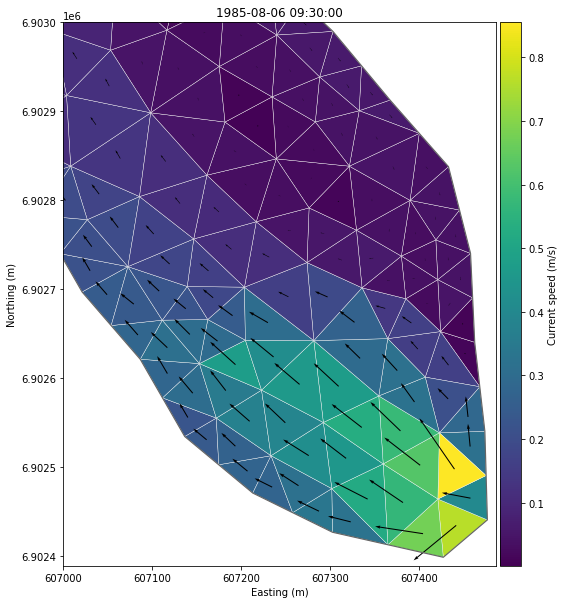

In [10]:
step = 1

cs = ds["Current speed"][step]
u = ds["U velocity"][step]
v = ds["V velocity"][step]
ec = dfs.element_coordinates
x = ec[:,0]
y = ec[:,1]
ax = dfs.plot(cs, label="Current speed (m/s)", figsize=(10,10))
ax.quiver(x, y, u, v, scale=6, minshaft=3)
ax.set_ylim([None, 6903000])
ax.set_xlim([607000, None])
ax.set_title(ds.time[step])
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)");

## Plot quiver on Cartesian overlay instead 
Create overset grid and interpolate data on to this

In [11]:
g=dfs.get_overset_grid(dx=100)
g

<mikeio.Grid2D>
x-axis: nx=17 points from x0=605927 to x1=607527 with dx=100
y-axis: ny=47 points from y0=6.90245e+06 to y1=6.90705e+06 with dy=100
Number of grid points: 799

In [12]:
interpolant = dfs.get_2d_interpolant(g.xy, n_nearest=4)
dsi = dfs.interp2d(ds, *interpolant, shape=(g.ny, g.nx))
dsi

<mikeio.Dataset>
Dimensions: (9, 47, 17)
Time: 1985-08-06 07:00:00 - 1985-08-07 03:00:00
Items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  U velocity <u velocity component> (meter per sec)
  2:  V velocity <v velocity component> (meter per sec)
  3:  Current speed <Current Speed> (meter per sec)

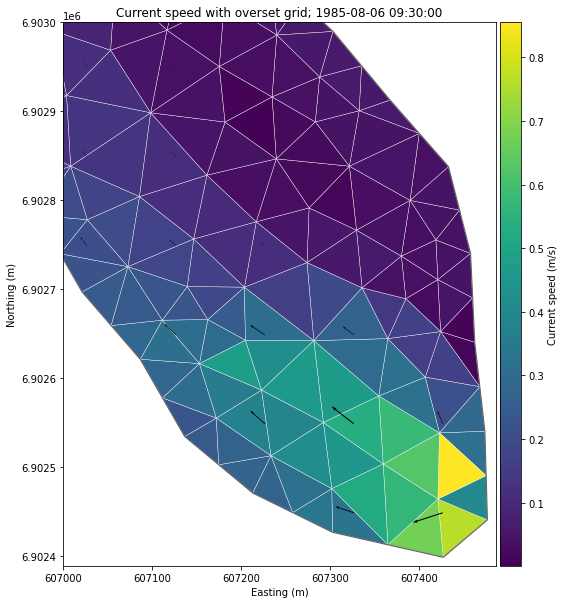

In [13]:
ax = dfs.plot(cs, label="Current speed (m/s)", figsize=(10,10))

u = dsi["U velocity"][step]
v = dsi["V velocity"][step]
ax.quiver(g.x, g.y, u, v, scale=8, minshaft=5)

ax.set_ylim([None, 6903000])
ax.set_xlim([607000, None])
ax.set_title(f'Current speed with overset grid; {ds.time[step]}')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)");

## Clean up

In [14]:
import os
os.remove("speed_direction.dfsu")